In [1]:
%config Completer.use_jedi = False

In [2]:
GPU_BOOL = False

In [3]:
import numpy as np
import pandas as pd

import glob, os

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.experimental import enable_halving_search_cv

from sklearn.model_selection import StratifiedKFold, HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

import xgboost as xgb

import shap

In [12]:
models = [
    'Presentation',
    'Access',
    'Cath Lab',
    'Medications',
    'PCI',
    'Closure'
]

In [4]:
presentation_vars = [col for col in list(pd.read_csv('../presentation.txt', header=None)[0]) if 'ND' not in col]
cath_lab_vars = list(pd.read_csv('../cath_lab.txt', header=None)[0])
med_vars = list(pd.read_csv('../meds.txt', header=None)[0])
pci_vars = list(pd.read_csv('../pci.txt', header=None)[0])
access_vars = ['Femoral', 'Radial']
closure_vars = [
    'closure_Other', 'closure_Manual_com','closure_Suture',
    'closure_Staple','closure_Sealant','closure_Patch',
    'closure_Mechanical','total_count_closure','closure_None'
]
outcome_var = ['Bleed']

all_vars = outcome_var + presentation_vars + access_vars + cath_lab_vars + med_vars + pci_vars + closure_vars

In [5]:
def correct_non_continuous(df):
    _df = df.copy()
    
    #These are variables from the initial df that were binary, and have now undergone Imputation.  This imputation
    #algorithm only provides floats, so the initial part of this function sets those imputed values to whichever
    #is closer, 0 or 1.  It then changes the entire Series to int.
    binary_vars = [
        'AA_BetaBlockers', 'AA_CaChannel', 'AA_LongActingNitrates', 'AA_OtherAgent', 'AA_Ranolazine', 'AntiAnginalMed',
        'CardioLVSD', 'ChronicLungDisease', 'CurrentDialysis', 'Diabetes', 'Dyslipidemia', 'FamilyHxCAD', 'HispOrig',
        'Hypertension', 'OnsetTimeEst', 'OnsetTimeNA', 'PreProcCKMBNM', 'Prior2weeksHF', 'PriorCABG', 'PriorCardiacArrest',
        'PriorCardioShock', 'PriorCVD', 'PriorHF', 'PriorMI', 'PriorPAD', 'PriorPCI', 'Smoker', 'STEMIFirstNoted',
        'ThromTherapy', 'ValveSurgery', 'CardiacTransplant', 'PeriopEval', 'PatientTransPCI', 'DiagCorAngio',
        'DissectionSeg', 'LeftHeartCath', 'PerfSeg', 'PreviousStent', 'PrevTreatedLesion', 'Thrombus', 'BifurcationLesion',
        'ChronicOcclusion', 'CTO', 'CulpritArtery', 'FFR', 'GuidewireLesion', 'IABP', 'InRestenosis', 'InThrombosis', 'IVUS',
        'MVSupport', 'OtherProcedure', 'PCICardioShock',
    ]
    
    binary_vars = [col for col in binary_vars if col in df.columns]
    
    for col in binary_vars:
        if df[col].notna().all():
            #print(col)
            temp = (_df[col] >= 0.5)
            _df[col] = temp.astype(int)
            
    #These are ordinal variables from the initial df.  As above, we now set variables to the nearest legal value, then
    #change the dtype to int.
    ordinal_vars = {
        'LesonComplexty':     [1, 2],
        'StentType':          [1, 2],
        'AnginalClass':       [1, 2, 3, 4, 5],
        'CADPresentation':    [1, 2, 3, 4, 5, 6],
        'PCIStatus':          [1, 2, 3, 4],
        'Prior2weekNYHA':     [1, 2, 3, 4],
        'DCathStatus':        [1, 2, 3, 4],
        'DCathTreatment':     [1, 2, 3, 4, 5],
        'PreProcTIMI':        [1, 2, 3, 4],
        'PreTIMI':            [0, 1, 2, 3],
        'IABPTiming':         [1, 2, 3],
        'LesionGraft':        [0, 1, 2, 3],
        'MVSupportTiming':    [1, 2, 3],
        'NEWSEQ':             [0, 1, 2, 3],
    }
    
    ordinal_vars = {col: val for (col, val) in ordinal_vars.items() if col in df.columns}
    
    for col, values in ordinal_vars.items():
        if _df[col].notna().all():
            #print(col)
            #Set anything more extreme than allowed values to most extreme allowed
            temp = _df[col].round().astype(int)
            temp[temp<values[0]] = values[0]
            temp[temp>values[-1]] = values[-1]
            _df[col] = temp.astype(int)
            
    return _df
        

In [6]:
%%time
stage_0_cols = presentation_vars
stage_1_cols = presentation_vars + access_vars
stage_2_cols = presentation_vars + access_vars + cath_lab_vars
stage_3_cols = presentation_vars + access_vars + cath_lab_vars + med_vars
stage_4_cols = presentation_vars + access_vars + cath_lab_vars + med_vars + pci_vars
stage_5_cols = presentation_vars + access_vars + cath_lab_vars + med_vars + pci_vars + closure_vars

y = pd.read_csv(f'../data/test_A_fold_0.csv', index_col=0, usecols=['Unnamed: 0']+outcome_var, squeeze=True)

CPU times: user 5.38 s, sys: 228 ms, total: 5.61 s
Wall time: 12.1 s


## MI Fold 0

In [7]:
MI_FOLD = 0

#MI_STAGE = 0

GPU_ID = 2 #0, 1, or 2 for balancing resources

#NAMING_STRING = f'fold_{MI_FOLD}_stage_{MI_STAGE}'

In [8]:
%%time
df = {
    0: correct_non_continuous(pd.read_csv(f'../data/test_A_fold_{MI_FOLD}.csv', index_col=0, usecols=['Unnamed: 0']+stage_0_cols)),
    1: correct_non_continuous(pd.read_csv(f'../data/test_A_fold_{MI_FOLD}.csv', index_col=0, usecols=['Unnamed: 0']+stage_1_cols)),
    2: correct_non_continuous(pd.read_csv(f'../data/test_B_fold_{MI_FOLD}.csv', index_col=0, usecols=['Unnamed: 0']+stage_2_cols)),
    3: correct_non_continuous(pd.read_csv(f'../data/test_B_fold_{MI_FOLD}.csv', index_col=0, usecols=['Unnamed: 0']+stage_3_cols)),
    4: correct_non_continuous(pd.read_csv(f'../data/test_C_fold_{MI_FOLD}.csv', index_col=0, usecols=['Unnamed: 0']+stage_4_cols)),
    5: correct_non_continuous(pd.read_csv(f'../data/test_C_fold_{MI_FOLD}.csv', index_col=0, usecols=['Unnamed: 0']+stage_5_cols)),
}

CPU times: user 1min 2s, sys: 5min 55s, total: 6min 57s
Wall time: 7min 25s


In [9]:
%%time
STAGE = 0

boost = xgb.Booster()
boost.load_model(f'models/fold_{MI_FOLD}_stage_{STAGE}_model_weights.json')
if GPU_BOOL:
    boost.set_param({"predictor": "gpu_predictor"})
    boost.set_param({"gpu_id": GPU_ID})

dm_data = xgb.DMatrix(df[STAGE], label=y)

contribs = boost.predict(dm_data, pred_contribs=True)
contribs.shape

CPU times: user 4min 35s, sys: 336 ms, total: 4min 35s
Wall time: 25.3 s


(554362, 110)

In [10]:
df_display = df[STAGE].copy()

In [11]:
%%time
df_display = df_display.rename(columns={
    'PreProcHgb': 'Preprocedure Hemoglobin',
    'CADPresentation': 'Coronary Artery Disease Presentation',
    'SHOCKPCIS': 'PCI Status and Shock Composite',
    'FEMALE': 'Female',
    #'PreProcHgbND': 'Preprocedure Hemoglobin Unknown',
    'PREHGBGT13': 'Preprocedure Hemoglobin > 13',
    'PriorPCI': 'Prior PCI',
    'PreProcTnl': 'Preprocedure Troponin-I',
    'PCIStatus': 'PCI Status',
    'AdmtSource_3': 'Patient not admitted from ER or Transfer',
    'PriorCardiacArrest': 'Prior Cardiac Arrest',
    'HDEF': 'Left Ventricular Ejection Fraction',
    'ChronicLungDisease': 'Chronic Lung Disease',
    'Prior2weeksHF': 'Heart Failure in Prior 2 Weeks',
    'GFR': 'Glomerular Filtration Rate',
    'PREHGBLE13': 'Preprocedure Hemoglobin <= 13',
    #'PreProcCKND': 'Preprocedure creatinine kinase unknown',
    'STEMI': 'ST Elevation MI on first ECG',
    'CKD3': 'Chronic Kidney Disease Stage 3'
})

CPU times: user 68 ms, sys: 552 ms, total: 620 ms
Wall time: 617 ms


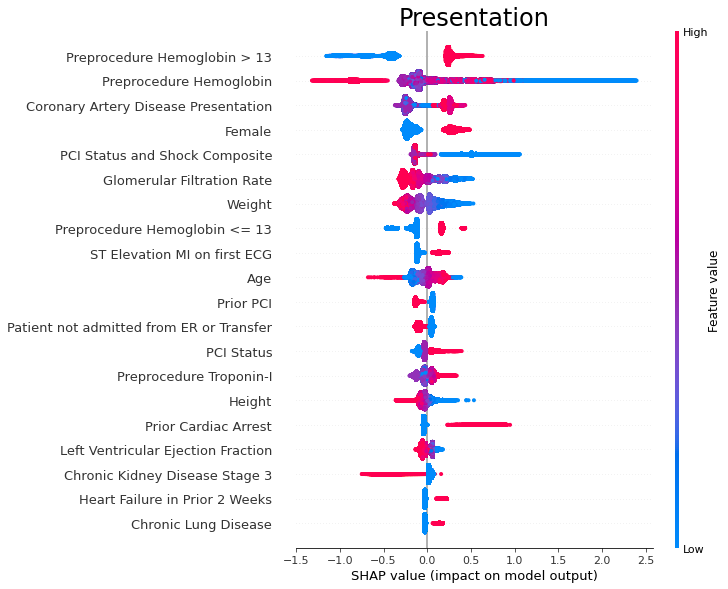

CPU times: user 54.5 s, sys: 7.02 s, total: 1min 1s
Wall time: 58.5 s


In [13]:
%%time
shap.summary_plot(contribs[:,:-1], df_display, show=False)
#plt.title(f'Model {STAGE+1}', fontdict={'fontsize': 24});
plt.title(models[STAGE], fontdict={'fontsize': 24});
plt.show()

In [14]:
%%time
STAGE = 1

df_display = df[STAGE].copy()

boost = xgb.Booster()
boost.load_model(f'models/fold_{MI_FOLD}_stage_{STAGE}_model_weights.json')
if GPU_BOOL:
    boost.set_param({"predictor": "gpu_predictor"})
    boost.set_param({"gpu_id": GPU_ID})

dm_data = xgb.DMatrix(df_display, label=y)

contribs = boost.predict(dm_data, pred_contribs=True)
contribs.shape

CPU times: user 4min 35s, sys: 8.2 s, total: 4min 43s
Wall time: 31.9 s


(554362, 112)

In [15]:
%%time
df_display = df_display.rename(columns={
    'PreProcHgb': 'Preprocedure Hemoglobin',
    'CADPresentation': 'Coronary Artery Disease Presentation',
    'SHOCKPCIS': 'PCI Status and Shock Composite',
    'FEMALE': 'Female',
    #'PreProcHgbND': 'Preprocedure Hemoglobin Unknown',
    'PREHGBGT13': 'Preprocedure Hemoglobin > 13',
    'PriorPCI': 'Prior PCI',
    'PreProcTnl': 'Preprocedure Troponin-I',
    'PCIStatus': 'PCI Status',
    'AdmtSource_3': 'Patient not admitted from ER or Transfer',
    'PriorCardiacArrest': 'Prior Cardiac Arrest',
    'HDEF': 'Left Ventricular Ejection Fraction',
    'ChronicLungDisease': 'Chronic Lung Disease',
    'Prior2weeksHF': 'Heart Failure in Prior 2 Weeks',
    'GFR': 'Glomerular Filtration Rate',
    'PREHGBLE13': 'Preprocedure Hemoglobin <= 13',
    #'PreProcCKND': 'Preprocedure creatinine kinase unknown',
    'STEMI': 'ST Elevation MI on first ECG',
    'CKD3': 'Chronic Kidney Disease Stage 3',
    'Femoral': 'Femoral Access',
    'Radial': 'Radial Access'
})

CPU times: user 32 ms, sys: 2.17 s, total: 2.2 s
Wall time: 2.2 s


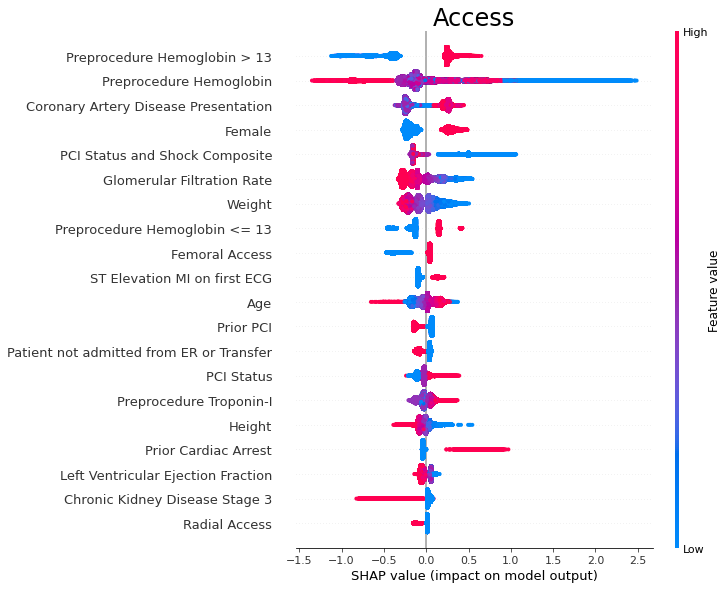

CPU times: user 54.3 s, sys: 10.9 s, total: 1min 5s
Wall time: 1min 2s


In [16]:
%%time
shap.summary_plot(contribs[:,:-1], df_display, show=False)
#plt.title(f'Model {STAGE+1}', fontdict={'fontsize': 24});
plt.title(models[STAGE], fontdict={'fontsize': 24});
plt.show()

In [17]:
STAGE = 2

df_display = df[STAGE].copy()

boost = xgb.Booster()
boost.load_model(f'models/fold_{MI_FOLD}_stage_{STAGE}_model_weights.json')
if GPU_BOOL:
    boost.set_param({"predictor": "gpu_predictor"})
    boost.set_param({"gpu_id": GPU_ID})

dm_data = xgb.DMatrix(df_display, label=y)

contribs = boost.predict(dm_data, pred_contribs=True)
contribs.shape

(554362, 141)

In [18]:
%%time
df_display = df_display.rename(columns={
    'PreProcHgb': 'Preprocedure Hemoglobin',
    'CADPresentation': 'Coronary Artery Disease Presentation',
    'SHOCKPCIS': 'PCI Status and Shock Composite',
    'FEMALE': 'Female',
    #'PreProcHgbND': 'Preprocedure Hemoglobin Unknown',
    'PREHGBGT13': 'Preprocedure Hemoglobin > 13',
    'PriorPCI': 'Prior PCI',
    'PreProcTnl': 'Preprocedure Troponin-I',
    'PCIStatus': 'PCI Status',
    'AdmtSource_3': 'Patient not admitted from ER or Transfer',
    'PriorCardiacArrest': 'Prior Cardiac Arrest',
    'HDEF': 'Left Ventricular Ejection Fraction',
    'ChronicLungDisease': 'Chronic Lung Disease',
    'Prior2weeksHF': 'Heart Failure in Prior 2 Weeks',
    'GFR': 'Glomerular Filtration Rate',
    'PREHGBLE13': 'Preprocedure Hemoglobin <= 13',
    #'PreProcCKND': 'Preprocedure creatinine kinase unknown',
    'STEMI': 'ST Elevation MI on first ECG',
    'CKD3': 'Chronic Kidney Disease Stage 3',
    'Femoral': 'Femoral Access',
    'Radial': 'Radial Access',
    'DCathStatus': 'Diagnostic Catheterization Status',
    'Thrombus': 'Thrombus Present',
    'PreTIMI': 'Preprocedure TIMI Flow',
    'PriorCABG': 'Prior CABG',
    'RCAStenosis': 'Right Coronary Artery Stenosis',
})

CPU times: user 108 ms, sys: 3.71 s, total: 3.82 s
Wall time: 3.82 s


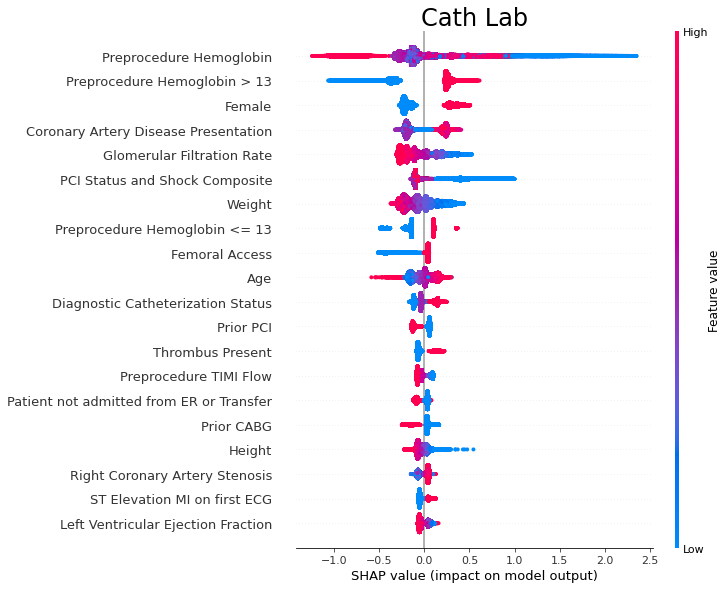

CPU times: user 55.8 s, sys: 11.9 s, total: 1min 7s
Wall time: 1min 4s


In [19]:
%%time
shap.summary_plot(contribs[:,:-1], df_display, show=False)
#plt.title(f'Model {STAGE+1}', fontdict={'fontsize': 24});
plt.title(models[STAGE], fontdict={'fontsize': 24});
plt.show()

In [20]:
STAGE = 3

df_display = df[STAGE].copy()

boost = xgb.Booster()
boost.load_model(f'models/fold_{MI_FOLD}_stage_{STAGE}_model_weights.json')
if GPU_BOOL:
    boost.set_param({"predictor": "gpu_predictor"})
    boost.set_param({"gpu_id": GPU_ID})

dm_data = xgb.DMatrix(df_display, label=y)

contribs = boost.predict(dm_data, pred_contribs=True)
contribs.shape

(554362, 151)

In [21]:
%%time
df_display = df_display.rename(columns={
    'PreProcHgb': 'Preprocedure Hemoglobin',
    'CADPresentation': 'Coronary Artery Disease Presentation',
    'SHOCKPCIS': 'PCI Status and Shock Composite',
    'FEMALE': 'Female',
    #'PreProcHgbND': 'Preprocedure Hemoglobin Unknown',
    'PREHGBGT13': 'Preprocedure Hemoglobin > 13',
    'PriorPCI': 'Prior PCI',
    'PreProcTnl': 'Preprocedure Troponin-I',
    'PCIStatus': 'PCI Status',
    'AdmtSource_3': 'Patient not admitted from ER or Transfer',
    'PriorCardiacArrest': 'Prior Cardiac Arrest',
    'HDEF': 'Left Ventricular Ejection Fraction',
    'ChronicLungDisease': 'Chronic Lung Disease',
    'Prior2weeksHF': 'Heart Failure in Prior 2 Weeks',
    'GFR': 'Glomerular Filtration Rate',
    'PREHGBLE13': 'Preprocedure Hemoglobin <= 13',
    #'PreProcCKND': 'Preprocedure creatinine kinase unknown',
    'STEMI': 'ST Elevation MI on first ECG',
    'CKD3': 'Chronic Kidney Disease Stage 3',
    'Femoral': 'Femoral Access',
    'Radial': 'Radial Access',
    'DCathStatus': 'Diagnostic Catheterization Status',
    'Thrombus': 'Thrombus Present',
    'PreTIMI': 'Preprocedure TIMI Flow',
    'PriorCABG': 'Prior Coronary Artery Bypass Graft',
    'RCAStenosis': 'Right Coronary Artery Stenosis',
    'PreOpMed7': 'Glycoprotein llb/llla Inhibitors',
    'PreOpMed3': 'Unfractionated Heparin',
    'PreOpMed5': 'Bivalirudin',
})

CPU times: user 120 ms, sys: 3.74 s, total: 3.86 s
Wall time: 3.86 s


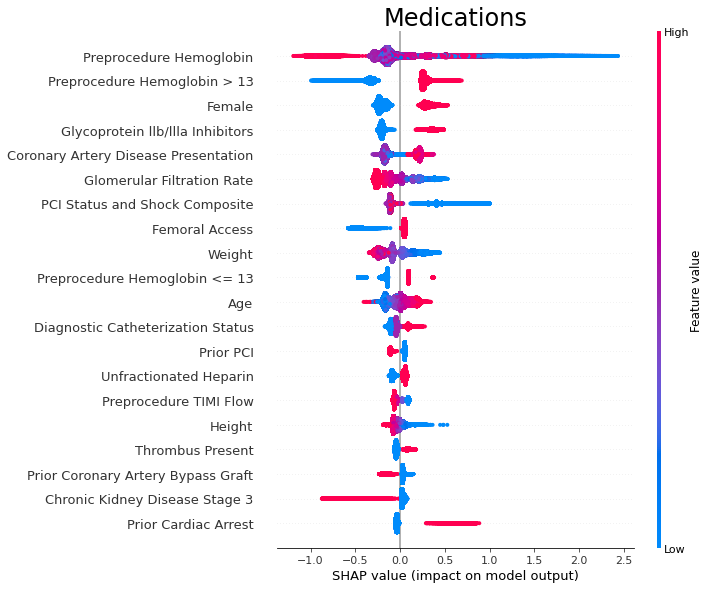

CPU times: user 55.5 s, sys: 11.3 s, total: 1min 6s
Wall time: 1min 3s


In [22]:
%%time
shap.summary_plot(contribs[:,:-1], df_display, show=False)
#plt.title(f'Model {STAGE+1}', fontdict={'fontsize': 24});
plt.title(models[STAGE], fontdict={'fontsize': 24});
plt.show()

In [23]:
STAGE = 4

df_display = df[STAGE].copy()

boost = xgb.Booster()
boost.load_model(f'models/fold_{MI_FOLD}_stage_{STAGE}_model_weights.json')
if GPU_BOOL:
    boost.set_param({"predictor": "gpu_predictor"})
    boost.set_param({"gpu_id": GPU_ID})


dm_data = xgb.DMatrix(df_display, label=y)

contribs = boost.predict(dm_data, pred_contribs=True)
contribs.shape

(554362, 256)

In [24]:
%%time
df_display = df_display.rename(columns={
    'PreProcHgb': 'Preprocedure Hemoglobin',
    'CADPresentation': 'Coronary Artery Disease Presentation',
    'SHOCKPCIS': 'PCI Status and Shock Composite',
    'FEMALE': 'Female',
    #'PreProcHgbND': 'Preprocedure Hemoglobin Unknown',
    'PREHGBGT13': 'Preprocedure Hemoglobin > 13',
    'PriorPCI': 'Prior PCI',
    'PreProcTnl': 'Preprocedure Troponin-I',
    'PCIStatus': 'PCI Status',
    'AdmtSource_3': 'Patient not admitted from ER or Transfer',
    'PriorCardiacArrest': 'Prior Cardiac Arrest',
    'HDEF': 'Left Ventricular Ejection Fraction',
    'ChronicLungDisease': 'Chronic Lung Disease',
    'Prior2weeksHF': 'Heart Failure in Prior 2 Weeks',
    'GFR': 'Glomerular Filtration Rate',
    'PREHGBLE13': 'Preprocedure Hemoglobin <= 13',
    #'PreProcCKND': 'Preprocedure creatinine kinase unknown',
    'STEMI': 'ST Elevation MI on first ECG',
    'CKD3': 'Chronic Kidney Disease Stage 3',
    'Femoral': 'Femoral Access',
    'Radial': 'Radial Access',
    'DCathStatus': 'Diagnostic Catheterization Status',
    'Thrombus': 'Thrombus Present',
    'PreTIMI': 'Preprocedure TIMI Flow',
    'PriorCABG': 'Prior Coronary Artery Bypass Graft',
    'RCAStenosis': 'Right Coronary Artery Stenosis',
    'PreOpMed7': 'Glycoprotein llb/llla Inhibitors',
    'PreOpMed3': 'Unfractionated Heparin',
    'PreOpMed5': 'Bivalirudin',
    'FluroTime': 'Fluoroscopy Time',
    'ContrastVol': 'Contrast Volume',
    'ICDEV_Drug_Eluting_Stent': 'Drug Eluting Stent',
})

CPU times: user 332 ms, sys: 5.59 s, total: 5.92 s
Wall time: 5.92 s


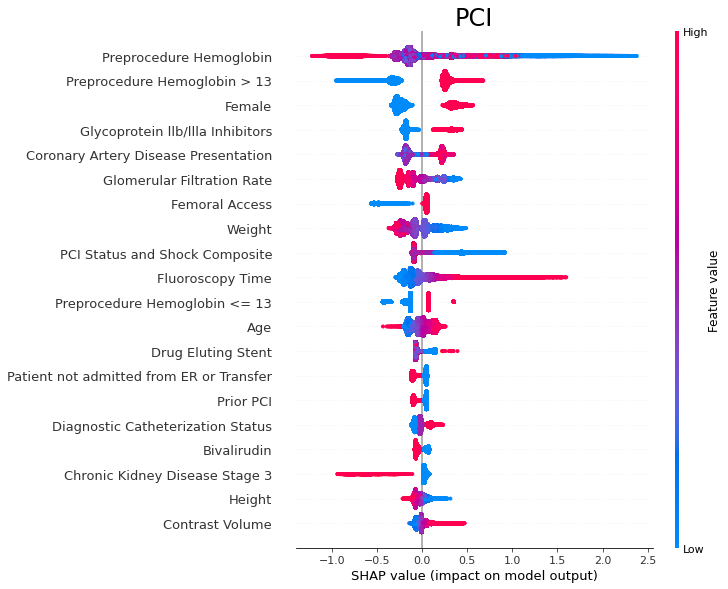

CPU times: user 55.4 s, sys: 14.5 s, total: 1min 9s
Wall time: 1min 6s


In [25]:
%%time
shap.summary_plot(contribs[:,:-1], df_display, show=False)
#plt.title(f'Model {STAGE+1}', fontdict={'fontsize': 24});
plt.title(models[STAGE], fontdict={'fontsize': 24});
plt.show()

In [26]:
STAGE = 5

df_display = df[STAGE].copy()

boost = xgb.Booster()
boost.load_model(f'models/fold_{MI_FOLD}_stage_{STAGE}_model_weights.json')
if GPU_BOOL:
    boost.set_param({"predictor": "gpu_predictor"})
    boost.set_param({"gpu_id": GPU_ID})


dm_data = xgb.DMatrix(df_display, label=y)

contribs = boost.predict(dm_data, pred_contribs=True)
contribs.shape

(554362, 265)

In [27]:
%%time
df_display = df_display.rename(columns={
    'PreProcHgb': 'Preprocedure Hemoglobin',
    'CADPresentation': 'Coronary Artery Disease Presentation',
    'SHOCKPCIS': 'PCI Status and Shock Composite',
    'FEMALE': 'Female',
    #'PreProcHgbND': 'Preprocedure Hemoglobin Unknown',
    'PREHGBGT13': 'Preprocedure Hemoglobin > 13',
    'PriorPCI': 'Prior PCI',
    'PreProcTnl': 'Preprocedure Troponin-I',
    'PCIStatus': 'PCI Status',
    'AdmtSource_3': 'Patient not admitted from ER or Transfer',
    'PriorCardiacArrest': 'Prior Cardiac Arrest',
    'HDEF': 'Left Ventricular Ejection Fraction',
    'ChronicLungDisease': 'Chronic Lung Disease',
    'Prior2weeksHF': 'Heart Failure in Prior 2 Weeks',
    'GFR': 'Glomerular Filtration Rate',
    'PREHGBLE13': 'Preprocedure Hemoglobin <= 13',
    #'PreProcCKND': 'Preprocedure creatinine kinase unknown',
    'STEMI': 'ST Elevation MI on first ECG',
    'CKD3': 'Chronic Kidney Disease Stage 3',
    'Femoral': 'Femoral Access',
    'Radial': 'Radial Access',
    'DCathStatus': 'Diagnostic Catheterization Status',
    'Thrombus': 'Thrombus Present',
    'PreTIMI': 'Preprocedure TIMI Flow',
    'PriorCABG': 'Prior Coronary Artery Bypass Graft',
    'RCAStenosis': 'Right Coronary Artery Stenosis',
    'PreOpMed7': 'Glycoprotein llb/llla Inhibitors',
    'PreOpMed3': 'Unfractionated Heparin',
    'PreOpMed5': 'Bivalirudin',
    'FluroTime': 'Fluoroscopy Time',
    'ContrastVol': 'Contrast Volume',
    'ICDEV_Drug_Eluting_Stent': 'Drug Eluting Stent',
    'closure_Manual_com': 'Closure: Manual Compression',
})

CPU times: user 176 ms, sys: 5.57 s, total: 5.75 s
Wall time: 5.75 s


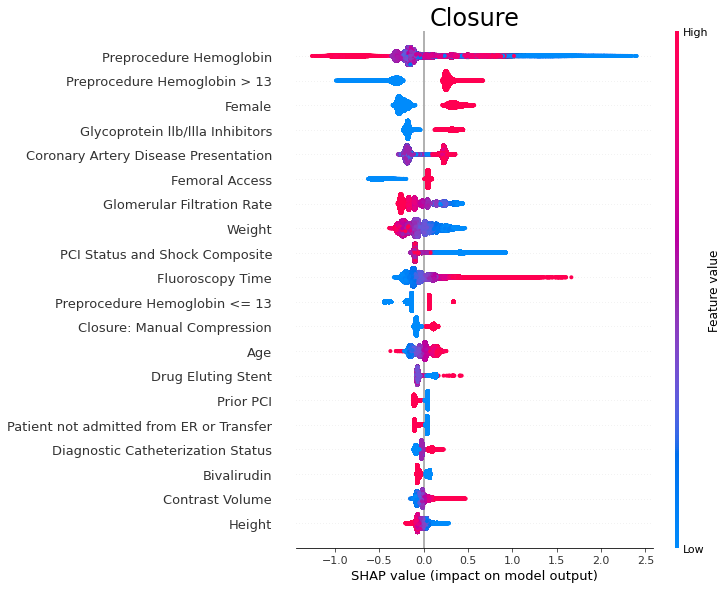

CPU times: user 55.3 s, sys: 14.7 s, total: 1min 10s
Wall time: 1min 6s


In [28]:
%%time
shap.summary_plot(contribs[:,:-1], df_display, show=False)
#plt.title(f'Model {STAGE+1}', fontdict={'fontsize': 24});
plt.title(models[STAGE], fontdict={'fontsize': 24});
plt.show()